# TCR Clonotypes

In [1]:
import sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [2]:
combined = sc.read('/scratch/batch_corrected_umap.h5ad')

In [3]:
# We only select the cells that have TCR data
combined = combined[combined.obs['has_tcr']=='True']

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [4]:
ir.pp.tcr_neighbors(combined, receptor_arms="all", dual_tcr="primary_only")
# running this would add 'clonotype' and 'clonotyp_size' to the dataframe, which is important for clonotype expansion pipeline
ir.tl.define_clonotypes(combined)

100%|██████████| 2177804/2177804 [00:36<00:00, 59991.79it/s]


In [7]:
ir.pp.tcr_neighbors(
    combined,
    metric="alignment",
    sequence="aa",
    cutoff=5,
    receptor_arms="all",
    dual_tcr="all",
)

100%|██████████| 2380422/2380422 [00:15<00:00, 152119.15it/s]


In [8]:
ir.tl.define_clonotype_clusters(combined, partitions="connected", sequence="aa", metric="alignment")

#### Just based on the clonotype network plot, primary tumor has far more varied clonotypes

In [9]:
ir.tl.clonotype_network(combined, min_size=4, sequence="aa", metric="alignment")

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


array([<AxesSubplot:title={'center':'group'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

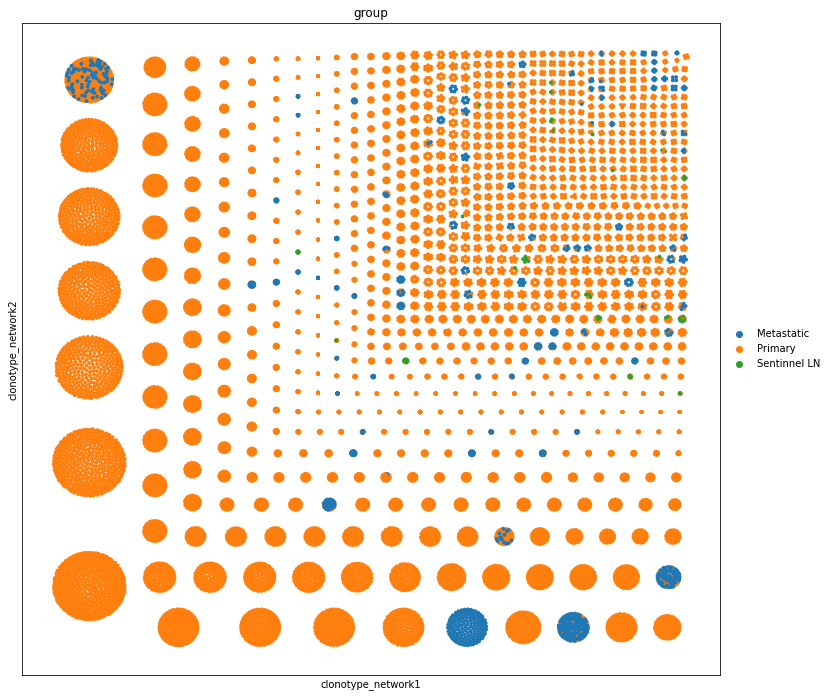

In [10]:
ir.pl.clonotype_network(combined, color="group", size=60, panel_size=(12, 12))

#### It is not surprised to see that primary and metastatic tumor tissues provide common clonotypes, but it is very interesting that 295 and 314 actually have a lot in common in their clonotypes.

array([<AxesSubplot:title={'center':'sample'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

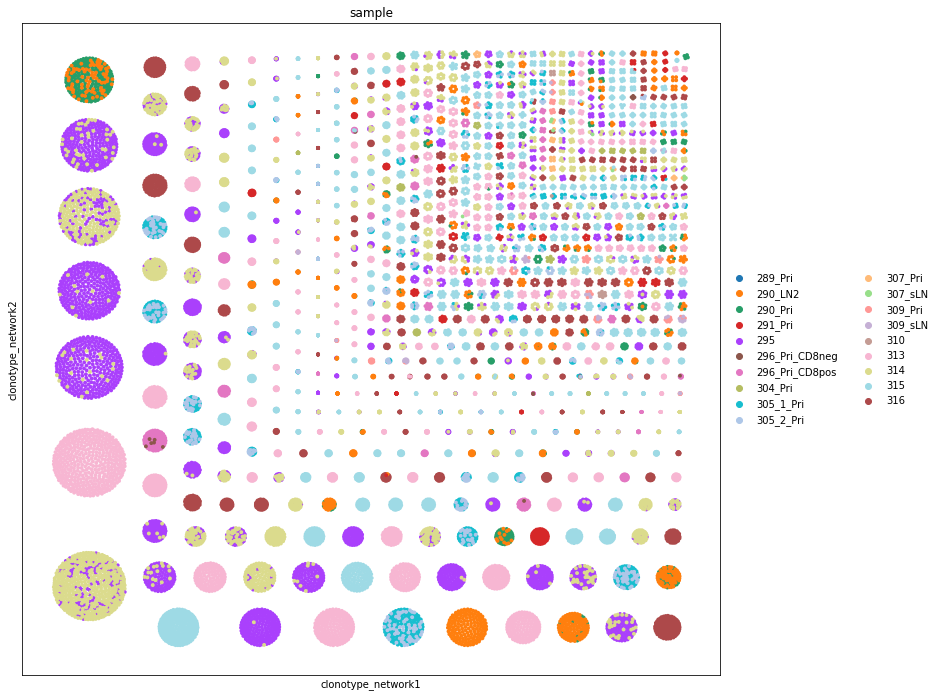

In [11]:
ir.pl.clonotype_network(combined, color="sample", size=60, panel_size=(12, 12))

# Clonotype Expansion

In [12]:
ir.tl.clonal_expansion(combined,clip_at=5)

#### Most of the expanded clonotypes belong to the primary tumor group

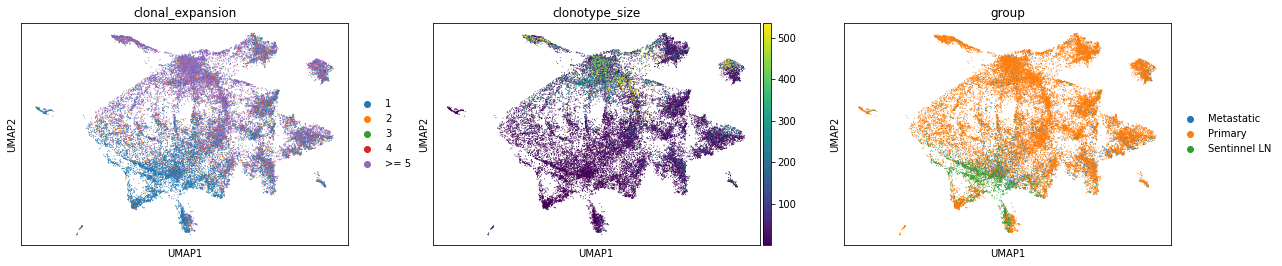

In [13]:
sc.pl.umap(combined, color=['clonal_expansion','clonotype_size','group'])

#### The largest clonotypes belong to cluster 18 and cluster 35 both are T/NKT. 

#### The ratio of clonally expanded T-cells is also higher in primary tumor group

<AxesSubplot:>

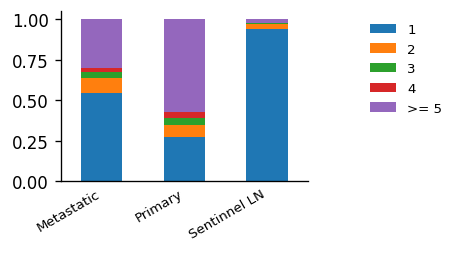

In [14]:
ir.pl.clonal_expansion(combined, groupby='group', clip_at=5)

#### Batch-wise, the ratio of clonally expanded T-cells are not drastically different which is a good signal.

<AxesSubplot:>

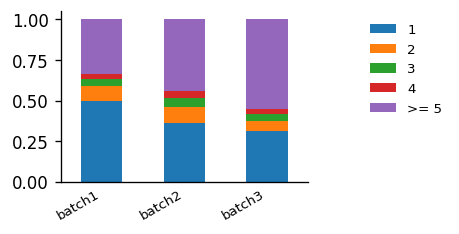

In [15]:
ir.pl.clonal_expansion(combined, groupby='bat', clip_at=5)

[]

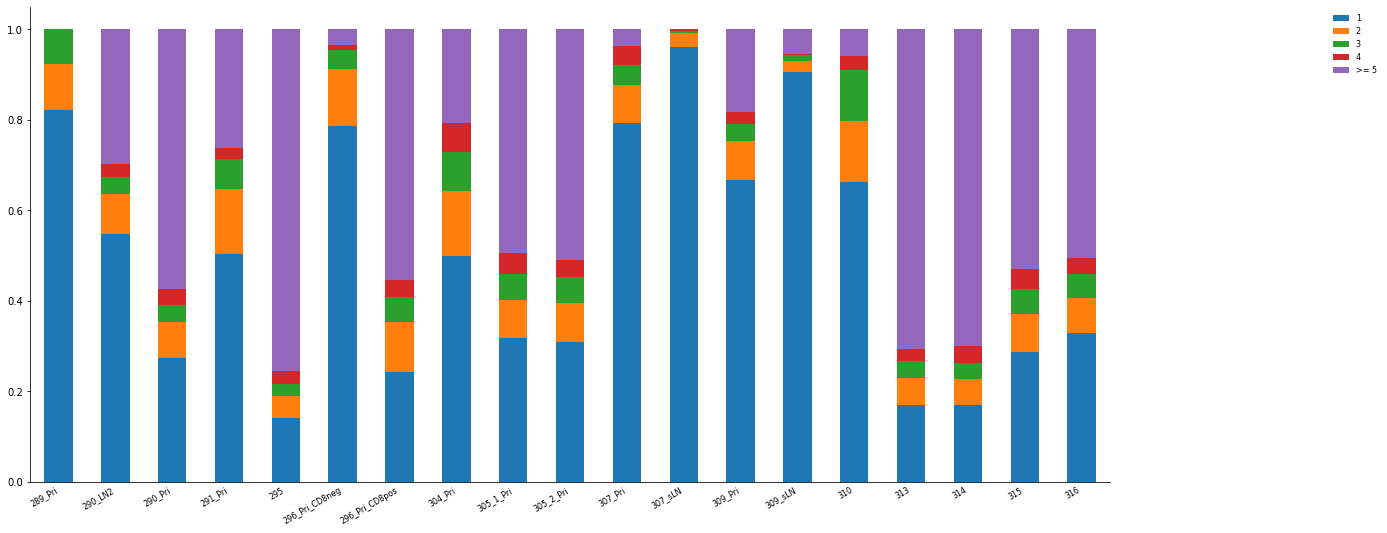

In [16]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(combined, groupby='sample', clip_at=5,ax=ax)
plt.plot()

[]

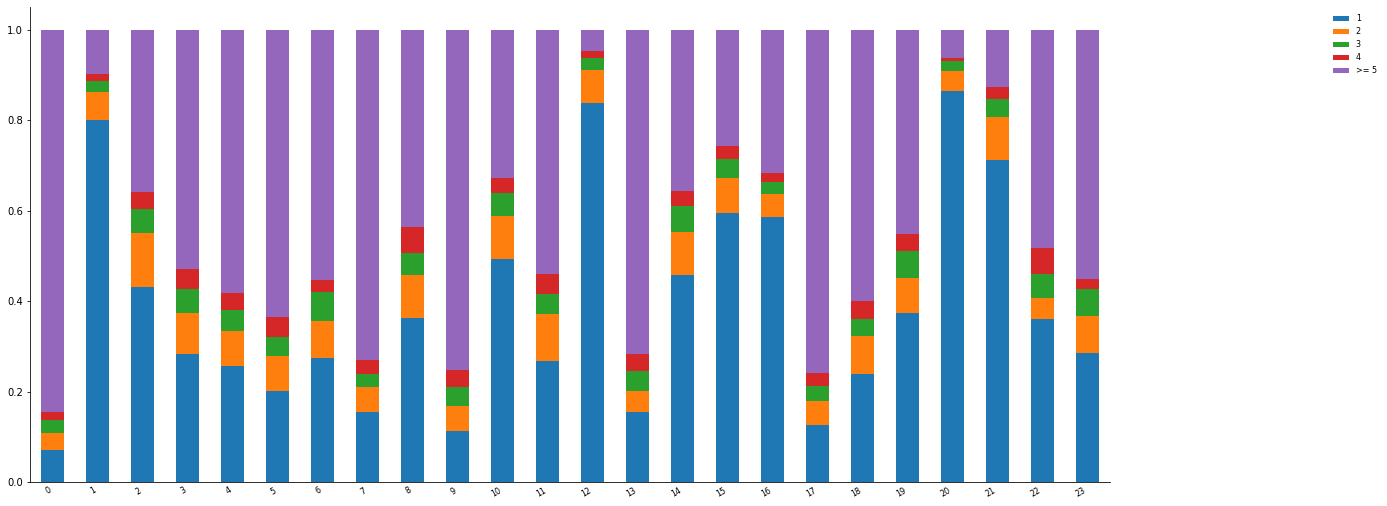

In [17]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(combined, groupby='leiden', clip_at=5,ax=ax)
plt.plot()

#### Clonotype frequency of primary tumor completely takes over 

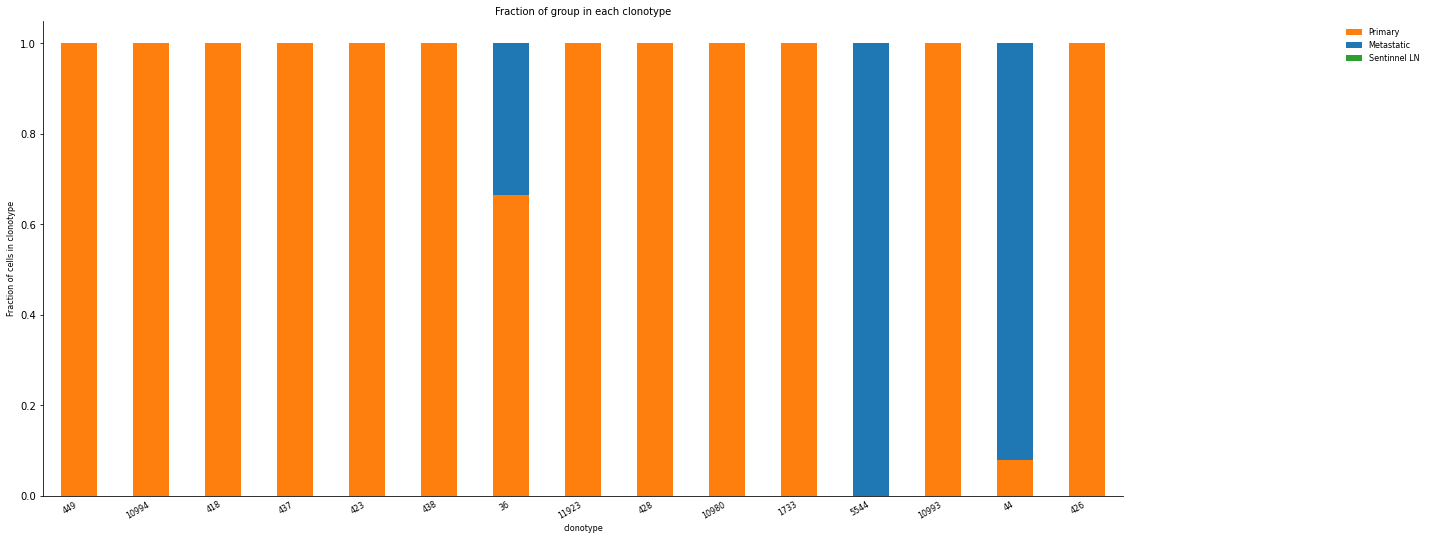

In [18]:
fig, ax = plt.subplots(figsize=(25, 12))
ax = ir.pl.group_abundance(combined, groupby="clonotype", target_col="group", sort='count',max_cols=15,normalize='clonotype', fig_kws={"dpi": 100},ax=ax)

[]

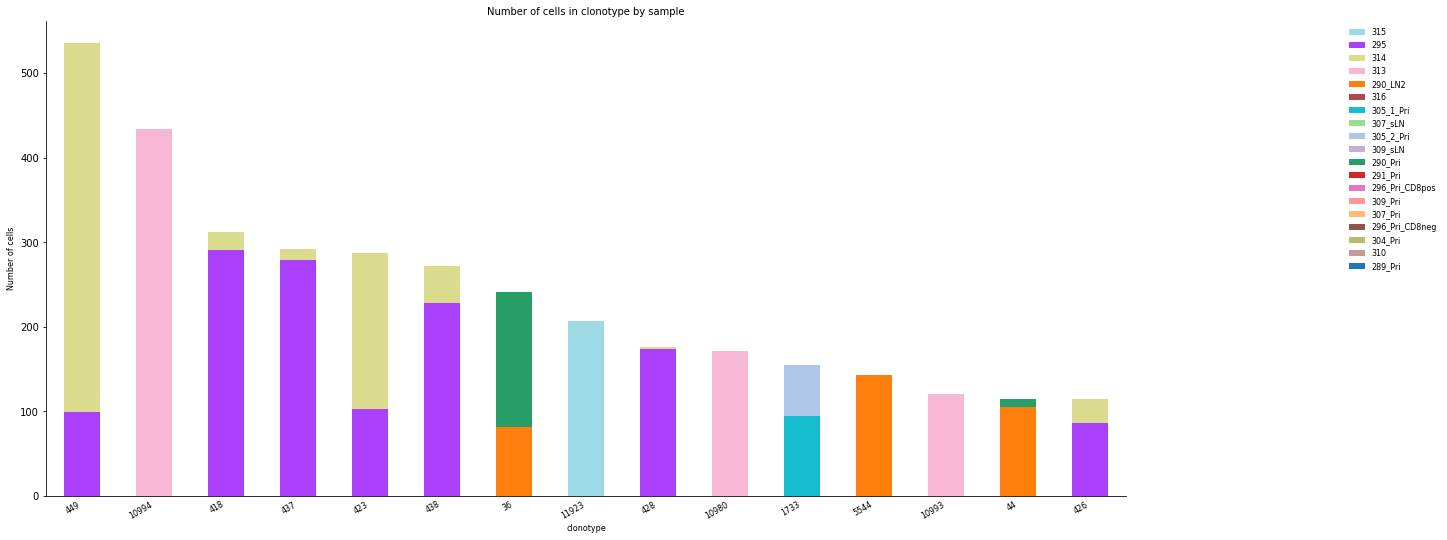

In [19]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(combined, groupby="clonotype", target_col="sample",max_cols=15,ax=ax)
plt.plot()

<AxesSubplot:title={'center':'Fraction of sample in each clonotype'}, xlabel='clonotype', ylabel='Fraction of cells in clonotype'>

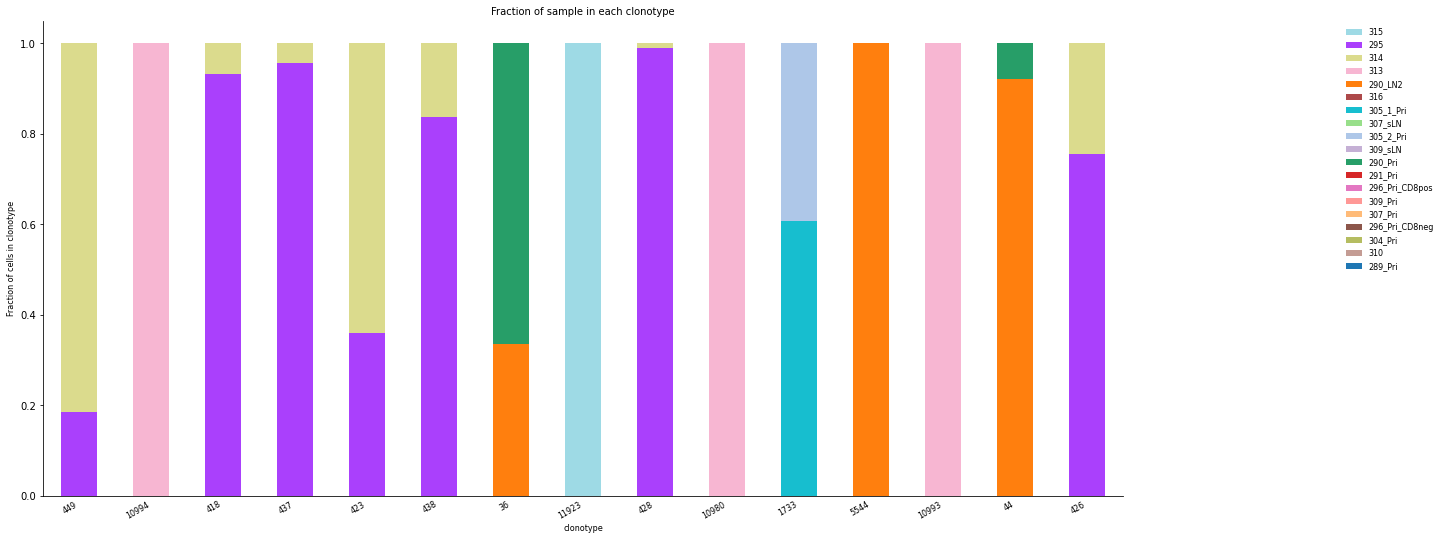

In [20]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(combined, groupby='clonotype', normalize='clonotype',target_col='sample',max_cols=15,ax=ax)


# Repertoire Simiarity

In [21]:
df, dst, lk = ir.tl.repertoire_overlap(combined, 'sample', inplace=False)

#### Primary and metastatic samples of the same patient are more closely related which is understandable. What's interesting in this plot is the high similarity between sample 295 and 314. This can also be seen from the clonotype network plot which shows that 295 and 314 do share a lot of common clonotypes.

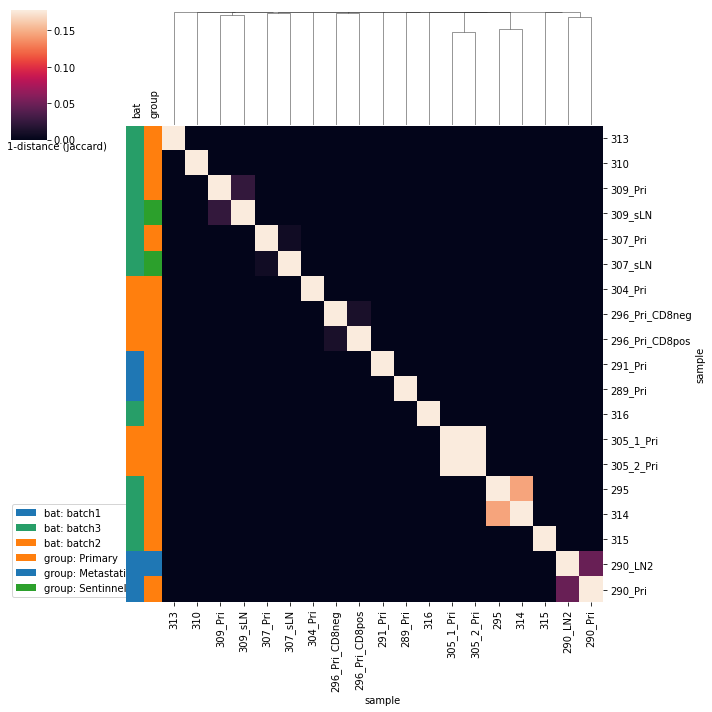

In [22]:
ir.pl.repertoire_overlap(combined, 'sample', heatmap_cats=['bat', 'group'])

## Clonal Diversity

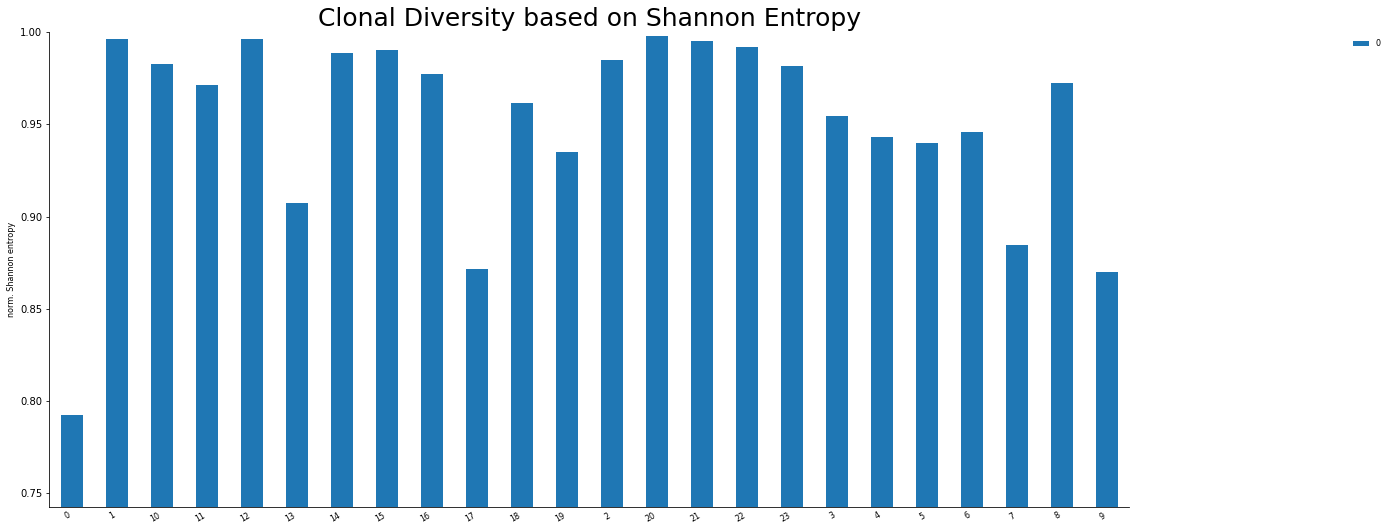

In [23]:
fig, ax = plt.subplots(figsize=(25,12))
ir.pl.alpha_diversity(combined, groupby='leiden', target_col='clonotype', vistype='bar',ax=ax)
plt.title('Clonal Diversity based on Shannon Entropy',fontsize=25)
plt.show()

## Top 5 Clones

In [24]:
# the number of top clonotypes we are interested in
n = 5
# extract the clonotype indeces of the top clonotypes
top_n_clonotypes = list(combined.obs['clonotype'].value_counts().index[:n])
# an argument to put in for the 'groups=' in sc.pl.umap, which would be the name label for the clonotypes in the umap plot
group_arg = ['top_'+str(i+1)+'_clonotype' for i in range(n)]

In [25]:
# store the top_n_clonotype assignments for each cell
cell_top_clonotypes = []

for cell in combined.obs.index:
    try:
        cell_top_clonotypes.append('top_'+str(top_n_clonotypes.index(combined.obs.loc[cell]['clonotype'])+1)+'_clonotype')
    except:
        cell_top_clonotypes.append('others')
        
# create new column to store top_n_clonotypes
combined.obs['top_n_clonotypes']=cell_top_clonotypes

In [26]:
all_cells_umap_x = list(coor[0] for coor in combined.obsm['X_umap'])
all_cells_umap_y = list(coor[1] for coor in combined.obsm['X_umap'])

In [28]:
top_clonotype_cell_coor = {}
for i in range(n):
    coor_x = [coor[0] for coor in combined[combined.obs['top_n_clonotypes']=='top_'+str(i+1)+'_clonotype'].obsm['X_umap']]
    coor_y = [coor[1] for coor in combined[combined.obs['top_n_clonotypes']=='top_'+str(i+1)+'_clonotype'].obsm['X_umap']]
    top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'] = [coor_x, coor_y]

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (32136×32136).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_nt_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (32136×32136).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (32136×32136).

These matrices should 

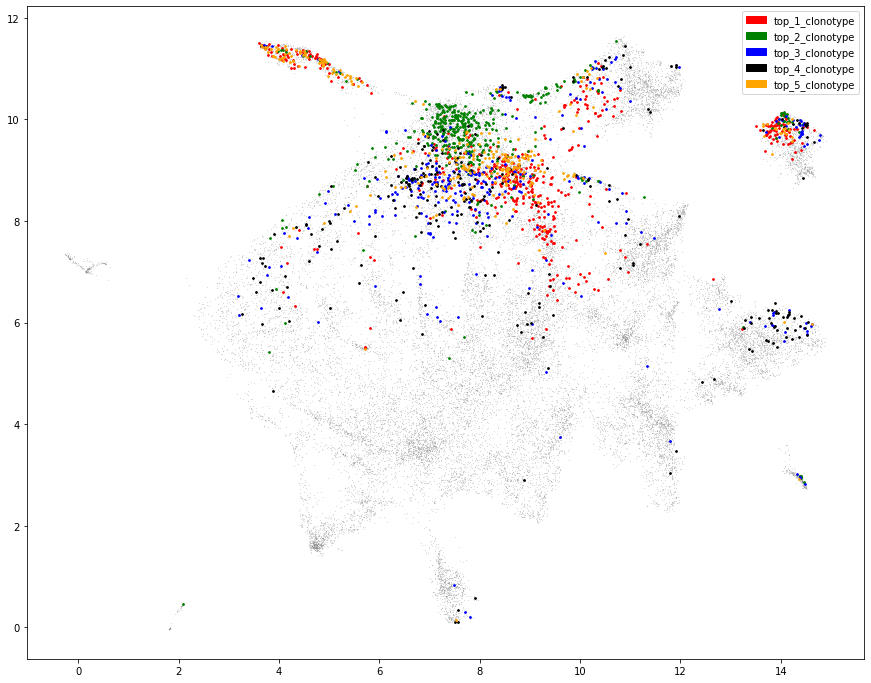

In [29]:
# legend_colors
color = ['red','green','blue','black','orange']
# texts to put for the legend
texts = ['top_'+str(i+1)+'_clonotype' for i in range(n)]
# customized patch shown in legend instead of just a dot which is barely seeable
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(all_cells_umap_x,all_cells_umap_y,0.01,color='grey')
for i in range(n):
    ax.scatter(top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][0],
               top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][1],3,color=color[i],
               label=str(i)+'_biggest__clonotype')
plt.legend(handles = patches) # use the customized patch legends
plt.show()

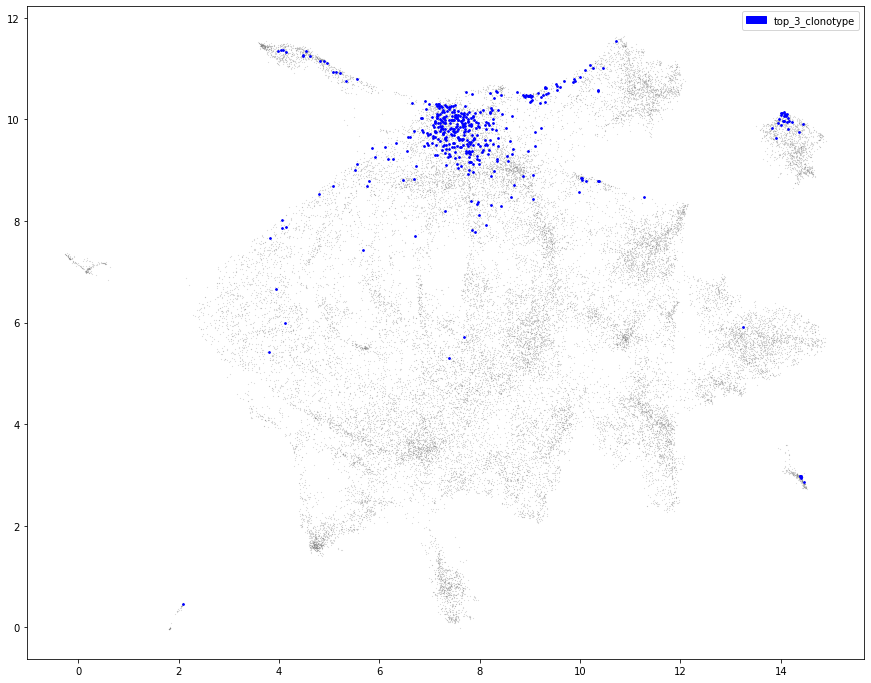

In [30]:
# i = 1-5 the top clonotype of interest
i = 2 
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(all_cells_umap_x, all_cells_umap_y,0.01,color='grey')
ax.scatter(top_clonotype_cell_coor['top_'+str(i)+'_clonotype'][0],
           top_clonotype_cell_coor['top_'+str(i)+'_clonotype'][1],3,color=color[i],
           label=str(i)+'_biggest__clonotype')
plt.legend(handles=[patches[i]])
plt.show()